In [4]:
import sys
import os
sys.path.append(r'C:\Users\minel\Documents\DOI_behavior')
import pstim_behavior2
from pstim_behavior2 import bout_applier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import master_functions

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
np.seterr(all="ignore")

from datetime import datetime as dt
from numba import jit
from pathlib import Path
from tqdm.auto import tqdm
from master_functions import mpWrapper, stimTimersMP, trialExcluderMP, cumThetaMP

from scipy.ndimage import gaussian_filter

In [5]:
parent_folder = r"C:\Users\minel\iCloudDrive\Documents\Duke University\Naumann Lab\DOI\Behavior\EK_6dpf_DOI_50ugml_20211227"

In [6]:
dfs = []
conditions = ['baseline']

with os.scandir(parent_folder) as entries:
    for entry in entries:
        if entry.is_dir():
            fish_path = os.path.join(parent_folder, entry)
            for cond in conditions:
                finalpath = os.path.join(fish_path, cond)

In [7]:
finalpath

'C:\\Users\\minel\\iCloudDrive\\Documents\\Duke University\\Naumann Lab\\DOI\\Behavior\\EK_6dpf_DOI_50ugml_20211227\\268\\baseline'

In [8]:
n = False
    # iterate through folder to find the files inside
with os.scandir(finalpath) as entries:
    for entry in entries:
        if entry.is_file():
            if entry.name.endswith('bout_df.h5'):
                bout_df_path = os.path.join(finalpath, entry.name)
            if entry.name.endswith('.txt'):
                stim_path = os.path.join(finalpath, entry.name)
                print(stim_path)
            if entry.name.endswith('behavior_log.csv'):
                behavior_path = os.path.join(finalpath, entry.name)
            if entry.name.endswith('.json'):
                metadata_path = os.path.join(finalpath, entry.name)

C:\Users\minel\iCloudDrive\Documents\Duke University\Naumann Lab\DOI\Behavior\EK_6dpf_DOI_50ugml_20211227\268\baseline\12_21__15_59.txt


In [9]:
if not n:
    with open(metadata_path) as json_file:
        metadata = json.load(json_file)
    start_time = dt.strptime(metadata['general']['t_protocol_start'].split('T')[1], '%H:%M:%S.%f').time()

    with open(stim_path) as file:
        contents = file.read()

    parsed = contents.split('\n')
    fish_details = parsed[0]
    stimulus_details = parsed[1:]

    fish_id = int(fish_details.split('_')[0].split('fish')[1])

    times = [i[:i.find('{')] for i in stimulus_details]

    tex_freq = False
    if 'tex_freq' in stimulus_details[0]:
        tex_freq = True
        _stimulus_dicts = []
        tex_freqs = []
        for i in stimulus_details:
            _stimulus_dicts.append(i[i.find('{'):i.find('}') + 1])
            tex_freqs.append(i[i.find('freq: '):].split(' ')[-1])

        stimulus_dicts = [eval(i[i.find('{'):]) for i in _stimulus_dicts if 'stationary_end' not in i]
        freq_fixer = []
        for i in range(len(tex_freqs)):
            if tex_freqs[i] == '}':
                freq_fixer.append(tex_freqs[i - 1])
            else:
                freq_fixer.append(tex_freqs[i])
    else:
        stimulus_dicts = [eval(i[i.find('{'):]) for i in stimulus_details if 'stationary_end' not in i]

    # mostly a binocular gratings fix, need to stack the tuples into two separate columns
    for stim in range(len(stimulus_dicts)):
        for item in stimulus_dicts[stim].copy():
            try:
                if len(stimulus_dicts[stim][item]) > 1 and type(stimulus_dicts[stim][item]) is not str:
                    for i in range(len(stimulus_dicts[stim][item])):
                        name = item + '_' + str(i)
                        stimulus_dicts[stim][name] = stimulus_dicts[stim][item][i]
                    stimulus_dicts[stim].pop(item)
            except:
                pass

    stim_df = pd.DataFrame(stimulus_dicts)

    final_stims = stim_df
    if tex_freq:
        final_stims.loc[:, 'freq'] = freq_fixer

In [10]:
# interpret the times and set up an array to measure elapsed times across experiment
ntime_array = []
stim_id_array = []

for i in range(len((times))):
    try:
        ntime_array.append(dt.strptime(times[i].split(' ')[1], '%H:%M:%S.%f:'))
    except ValueError:
        ntime_array.append(dt.strptime(times[i].split(' ')[1], '%H:%M:%S:'))

    stim_id_array.append(int(times[i].split(' ')[2]))

stim_df.loc[:, 'stim_index'] = stim_id_array
if stim_df.stim_index.max() <= 0:
    print('no trials started')

ntime_array = ntime_array[1:]

In [11]:
t_counter = []
for t in np.diff(ntime_array):
    t_counter.append(t.total_seconds())
    
t_ascending = np.cumsum(t_counter)
t_ascending = np.insert(t_ascending, 0, 0)

t_ascending

array([   0.      ,  300.000015,  302.999851,  333.00367 ,  336.00273 ,
        366.00525 ,  369.005165,  399.00605 ,  402.006235,  432.008513,
        435.008091,  465.009574,  468.010565,  498.011001,  501.010457,
        531.012797,  534.014417,  564.014511,  567.014387,  597.016273,
        600.016454,  630.018263,  633.018147,  663.019486,  666.018917,
        696.021699,  699.02104 ,  729.023055,  732.022183,  762.023298,
        765.024153,  795.025659,  798.02524 ,  828.026788,  831.026202,
        861.028219,  864.027762,  894.029636,  897.029649,  927.031723,
        930.030836,  960.032155,  963.032329,  993.039844,  996.03657 ,
       1026.038268, 1029.038182, 1059.040106, 1062.039757, 1092.041169,
       1095.040437, 1125.044059, 1128.04262 , 1158.044091, 1161.044083,
       1191.045429, 1194.044444, 1224.047352, 1227.046909, 1257.049667,
       1260.049283, 1290.053328, 1293.053108, 1323.055013, 1326.054543,
       1356.056788, 1359.055816, 1389.058256, 1392.057786, 1422.

In [12]:
rawt_array = []
for i in range(len(times)):
    try:
        rawt_array.append(str(ntime_array[i])[11:])
    except:
        pass

In [13]:
final_stims = final_stims.iloc[1:]
final_stims.loc[:, 't'] = t_ascending
final_stims.loc[:, 'raw_t'] = rawt_array
stimuli = final_stims
stimuli

,stim_type,velocity,angle,stat_time,stim_name,duration,stim_index,t,raw_t
1,s,0.000,0,0,habituation,300.0,0,0.000000,16:06:06.972620
2,s,0.000,180,3,forward,33.0,1,300.000015,16:11:06.972635
3,s,-0.025,180,3,forward,33.0,1,302.999851,16:11:09.972471
4,s,0.000,270,3,right,33.0,2,333.003670,16:11:39.976290
5,s,-0.025,270,3,right,33.0,2,336.002730,16:11:42.975350
...,...,...,...,...,...,...,...,...,...
77,s,-0.025,90,3,left,33.0,38,1524.063230,16:31:31.035850
78,s,0.000,270,3,right,33.0,39,1554.064807,16:32:01.037427
79,s,-0.025,270,3,right,33.0,39,1557.065746,16:32:04.038366
80,s,0.000,90,3,left,33.0,40,1587.066072,16:32:34.038692


In [15]:
stim_changes = stimuli.stim_type
s = []
stims = []
moving = []

for i in range(len(stim_changes)):
    if stimuli.iloc[i].stim_type == 'centering':
        s.append(stimuli.iloc[i + 1].t)
        stims.append(stimuli.iloc[i + 1].stim_index)
        moving.append(0)
    elif stimuli.iloc[i].stim_type != 'centering':
        s.append(stimuli.iloc[i].t)
        stims.append(stimuli.iloc[i].stim_index)
        moving.append(1)

In [16]:
behave_df = pd.read_csv(behavior_path,  sep=';', dtype=np.float32)

In [17]:
last_t = (stimuli[-1:].t + stimuli[-1:].duration - stimuli[-1:].stat_time).values[0]
last_t

1620.0657840000006

In [18]:
for i in range(len(s)):
    try:
        row_s = behave_df[behave_df.t >= s[i]].index[0]
    except IndexError:
        break
    try:
        row_e = behave_df[behave_df.t >= s[i + 1]].index[0] - 1
    except IndexError:
        row_e = behave_df[behave_df.t >= last_t].index[0] - 1
    behave_df.loc[row_s:row_e, 'stim_index'] = stims[i]
    behave_df.loc[row_s:row_e, 'motion'] = moving[i]

In [19]:
try:
    behave_df = behave_df[behave_df.stim_index.notna()]
except AttributeError:
    behave_df.loc[:, 'stim_index'] = -1
    behave_df.loc[:, 'motion'] = 0

In [20]:
behave_df

,Unnamed: 0,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,biggest_area,t,stim_index,motion
4,4.0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,1550.0,0.003990,0.0,1.0
5,5.0,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,1575.0,0.010971,0.0,1.0
6,6.0,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,1575.0,0.016956,0.0,1.0
7,7.0,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,1400.0,0.023936,0.0,1.0
8,8.0,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,1575.0,0.029920,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242880,242880.0,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,1300.0,1620.038940,40.0,1.0
242881,242881.0,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,1225.0,1620.045898,40.0,1.0
242882,242882.0,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,1225.0,1620.051880,40.0,1.0
242883,242883.0,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,1325.0,1620.058838,40.0,1.0


In [21]:
stimuli

,stim_type,velocity,angle,stat_time,stim_name,duration,stim_index,t,raw_t
1,s,0.000,0,0,habituation,300.0,0,0.000000,16:06:06.972620
2,s,0.000,180,3,forward,33.0,1,300.000015,16:11:06.972635
3,s,-0.025,180,3,forward,33.0,1,302.999851,16:11:09.972471
4,s,0.000,270,3,right,33.0,2,333.003670,16:11:39.976290
5,s,-0.025,270,3,right,33.0,2,336.002730,16:11:42.975350
...,...,...,...,...,...,...,...,...,...
77,s,-0.025,90,3,left,33.0,38,1524.063230,16:31:31.035850
78,s,0.000,270,3,right,33.0,39,1554.064807,16:32:01.037427
79,s,-0.025,270,3,right,33.0,39,1557.065746,16:32:04.038366
80,s,0.000,90,3,left,33.0,40,1587.066072,16:32:34.038692


In [22]:
smol_stim_df = stimuli.loc[:, ['stim_index', 'stim_type', 'angle', 'stim_name', 'stat_time', 'duration']].drop_duplicates(
    subset='stim_index', keep='first')
smol_stim_df

,stim_index,stim_type,angle,stim_name,stat_time,duration
1,0,s,0,habituation,0,300.0
2,1,s,180,forward,3,33.0
4,2,s,270,right,3,33.0
6,3,s,90,left,3,33.0
8,4,s,180,forward,3,33.0
10,5,s,270,right,3,33.0
12,6,s,0,backward,3,33.0
14,7,s,90,left,3,33.0
16,8,s,0,backward,3,33.0
18,9,s,180,forward,3,33.0


In [23]:
fulldf = pd.merge(behave_df, smol_stim_df, on='stim_index', how='left')
fulldf.loc[:, 'stim_type'] = fulldf.stim_type.astype('category')
fulldf.loc[:, 'stim_name'] = fulldf.stim_name.astype('category')
fulldf.loc[:, 'fish_id'] = fish_id
fulldf.fish_id = pd.Series(fulldf.fish_id.values, dtype='int16')
fulldf.angle = pd.Series(fulldf.angle.values, dtype='int16')
fulldf.motion = pd.Series(fulldf.motion.values, dtype='float16')
fulldf.drop('Unnamed: 0', axis=1, inplace=True)
fulldf = fulldf[fulldf.f0_x.notna()]
fulldf

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,biggest_area,t,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id
0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,1550.0,0.003990,0.0,1.0,s,0,habituation,0,300.0,268
1,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,1575.0,0.010971,0.0,1.0,s,0,habituation,0,300.0,268
2,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,1575.0,0.016956,0.0,1.0,s,0,habituation,0,300.0,268
3,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,1400.0,0.023936,0.0,1.0,s,0,habituation,0,300.0,268
4,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,1575.0,0.029920,0.0,1.0,s,0,habituation,0,300.0,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242876,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,1300.0,1620.038940,40.0,1.0,s,90,left,3,33.0,268
242877,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,1225.0,1620.045898,40.0,1.0,s,90,left,3,33.0,268
242878,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,1225.0,1620.051880,40.0,1.0,s,90,left,3,33.0,268
242879,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,1325.0,1620.058838,40.0,1.0,s,90,left,3,33.0,268


In [24]:
fulldf = bout_applier(fulldf, metadata_path)
loc_fish_details = fish_details.replace(':', '.')

In [25]:
fulldf

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,...,t,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id,bout
0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,...,0.003990,0.0,1.0,s,0,habituation,0,300.0,268,NaN
1,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,...,0.010971,0.0,1.0,s,0,habituation,0,300.0,268,0.0
2,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,...,0.016956,0.0,1.0,s,0,habituation,0,300.0,268,0.0
3,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,...,0.023936,0.0,1.0,s,0,habituation,0,300.0,268,0.0
4,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,...,0.029920,0.0,1.0,s,0,habituation,0,300.0,268,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242876,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,...,1620.038940,40.0,1.0,s,90,left,3,33.0,268,NaN
242877,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,...,1620.045898,40.0,1.0,s,90,left,3,33.0,268,NaN
242878,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,...,1620.051880,40.0,1.0,s,90,left,3,33.0,268,NaN
242879,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,...,1620.058838,40.0,1.0,s,90,left,3,33.0,268,NaN


In [26]:
dataframe = mpWrapper(stimTimersMP, fulldf)
dataframe

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,...,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id,bout,stim_time
0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,...,0.0,1.0,s,0,habituation,0,300.0,268,NaN,0.000000
1,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.006991
2,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.013982
3,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.020973
4,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.027964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242876,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.968560
242877,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.975230
242878,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.981900
242879,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.988570


In [27]:
dataframe = mpWrapper(trialExcluderMP, dataframe, big=True)
dataframe

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,...,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id,bout,stim_time
0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,...,0.0,1.0,s,0,habituation,0,300.0,268,NaN,0.000000
1,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.006991
2,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.013982
3,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.020973
4,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,...,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.027964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242876,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.968560
242877,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.975230
242878,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.981900
242879,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,...,40.0,1.0,s,90,left,3,33.0,268,NaN,32.988570


In [43]:
df = dataframe
sub = df[(df.stim_index==0) & (df.bout == 5)]
sub

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,...,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id,bout,stim_time
904,295.303009,0.001323,1141.416870,0.023072,-2.572343,0.000197,0.044074,0.025983,0.065163,0.055550,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.613796
905,295.139648,-0.078005,1141.274658,-0.056569,-2.581175,-0.004154,0.033683,0.054480,0.075088,0.062690,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.620787
906,295.066284,-0.075765,1141.203125,-0.063755,-2.584654,-0.003829,0.036334,0.053789,0.072046,0.059481,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.627778
907,295.209656,0.029782,1141.311401,0.019105,-2.566263,0.006878,0.011831,0.002685,0.054770,0.057961,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.634769
908,297.435791,1.087632,1142.880493,0.766010,-2.561833,0.005699,0.044034,0.029935,0.013580,-0.003535,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.641760
909,298.523438,1.087632,1143.646484,0.766010,-2.556134,0.005699,0.044034,0.029935,0.013580,-0.003535,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.648751
910,299.611084,1.087632,1144.412598,0.766010,-2.550436,0.005699,0.044034,0.029935,0.013580,-0.003535,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.655742
911,323.002563,0.000000,1095.713745,0.000000,2.738111,0.000000,0.008902,0.071907,0.024493,-0.014318,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.662733
912,324.903748,0.950588,1095.704956,-0.004383,3.004026,0.132959,-0.064088,-0.015404,-0.054796,0.164402,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.669724
913,329.285889,2.844075,1097.486816,0.981443,3.178722,0.155995,6.156170,6.256088,6.258378,6.310852,...,0.0,1.0,s,0,habituation,0,300.0,268,5.0,5.676715


In [47]:
angle = (sub.f0_theta.values[-1] - sub.f0_theta.values[0]) * 180 / np.pi

In [48]:
angle in range(-180, 180)

False

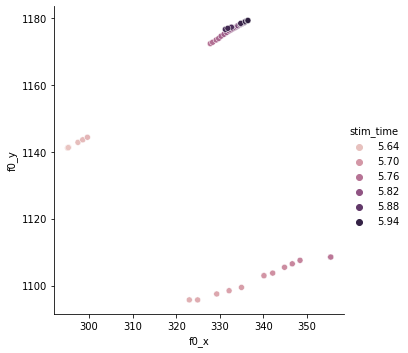

In [45]:
sns.relplot(x='f0_x', y='f0_y', hue='stim_time', data=df[(df.stim_index==0) & (df.bout == 5)])

In [51]:
parent_folder = fr"C:\Users\minel\iCloudDrive\Documents\Duke University\Naumann Lab\DOI\Behavior\locomotor_behavior\EK_6dpf_DOI_0ugml_20211111"
df_path = os.path.join(parent_folder, parent_folder[parent_folder.rfind('\\')+1:] + '_finaldf.h5')
df = pd.read_hdf(df_path)

In [54]:
df.stim_time

0              0.000000
1              0.007174
2              0.014348
3              0.021522
4              0.028696
               ...     
5838895    10621.357874
5838896    10621.365329
5838897    10621.372785
5838898    10621.380240
5838899    10621.387695
Name: stim_time, Length: 5838900, dtype: float64

In [55]:
thetas = [0.009072, 0.018354, -0.011672, 0.005817]
np.cumsum(thetas)

array([0.009072, 0.027426, 0.015754, 0.021571])

In [258]:
inds = sub.index
thetas = sub.f0_vtheta.values
dsts = sub.f0_vx.values
cum_theta = np.cumsum(thetas)
cum_dst = np.cumsum(dsts)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            44966, 44967, 44968, 44969, 44970, 44971, 44972, 44973, 44974,
            44975],
           dtype='int64', length=42912)

In [3]:
np.full((2,), 0.0)

array([0., 0.])

In [231]:
dataframe = mpWrapper(cumThetaMP, dataframe)
dataframe

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,biggest_area,t,stim_index,motion,stim_type,angle,stim_name,stat_time,duration,fish_id,bout,stim_time,cum_theta,cum_dst
0,456.137787,-0.010552,1035.604980,-0.105534,-1.171273,-0.010920,0.009072,0.018354,-0.011672,0.005817,1550.0,0.003990,0.0,1.0,s,0,habituation,0,300.0,268,NaN,0.000000,-0.010920,-0.010552
1,456.157562,0.004057,1035.393555,-0.156553,-1.178223,-0.009008,0.006775,0.015353,-0.017890,0.002431,1575.0,0.010971,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.006991,-0.019928,-0.006494
2,456.166473,0.006402,1035.096436,-0.224261,-1.129957,0.018591,-0.068012,-0.073258,-0.061353,-0.073637,1575.0,0.016956,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.013982,-0.001337,-0.000092
3,456.169647,0.004847,1034.861694,-0.229323,-1.126857,0.011126,-0.026506,-0.056136,-0.042111,-0.058269,1400.0,0.023936,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.020973,0.009789,0.004755
4,456.159882,-0.002202,1034.627319,-0.231756,-1.167308,-0.013727,0.009691,0.020986,-0.011462,0.023652,1575.0,0.029920,0.0,1.0,s,0,habituation,0,300.0,268,0.0,0.027964,-0.003938,0.002554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242876,622.325562,0.371412,505.428772,-0.080739,21.849335,0.015717,-0.000250,-0.048529,-0.066403,-0.079420,1300.0,1620.038940,40.0,1.0,s,90,left,3,33.0,268,NaN,32.968560,-36.371685,128.353668
242877,622.729675,0.387162,505.353699,-0.078011,21.842352,0.004779,-0.029866,-0.040881,-0.048679,-0.024137,1225.0,1620.045898,40.0,1.0,s,90,left,3,33.0,268,NaN,32.975230,-36.366905,128.740829
242878,623.021790,0.341375,505.277222,-0.077265,21.835876,-0.000644,-0.026668,-0.036034,-0.046398,-0.017667,1225.0,1620.051880,40.0,1.0,s,90,left,3,33.0,268,NaN,32.981900,-36.367550,129.082199
242879,623.294312,0.308223,505.213104,-0.070939,21.832808,-0.001813,-0.034591,-0.040921,-0.031074,-0.023831,1325.0,1620.058838,40.0,1.0,s,90,left,3,33.0,268,NaN,32.988570,-36.369362,129.390427


In [205]:
pd.set_option('display.max_columns', None)

In [30]:
create_newdf(parent_folder)

[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24
 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36
 36 37 37 38 38 39 39 40 40]


In [27]:
pd.set_option('display.max_rows', 500)

In [2]:
x0 = 608 # x-coord of the center
y0 = 608 # y-coord of the center
roi = (1216, 1216) # roi of camera
radius = min(roi[0], roi[1]) / (2*np.sqrt(2))

bout_duration_threshold = 1 # in seconds
bout_threshold = 120 # Eliminate fish with average bouts higher than 120 (control for tracking issues)
baseline_threshold = 10 # Eliminate fish with average baseline habituation bouts less than 10 (control for non-moving fish)

habit_duration = 300
baseline_loco_duration = 600
drug_loco_duration = 10800 

In [1]:
def create_newboutdf(parent_folder):
    df_path = os.path.join(parent_folder, parent_folder[parent_folder.rfind('\\')+1:] + '_finaldf.h5')
    df = pd.read_hdf(df_path) 
    
    ids = []
    conditions = []
    stim_names = []
    bout_labels = []
    dsts = []
    thetas = []
    bout_starts = []
    bout_durations = []
    cum_bout_starts = []
    stim_t_tots = []
    dist_from_centers = []
    in_centers = []

    _boutdf = df[df.f0_x.notna()]

    for _id in _boutdf.fish_id.unique():
        iddf = _boutdf[_boutdf.fish_id == _id]
        cum_time = 0
        for cond in iddf.condition.unique():
            conddf = iddf[iddf.condition == cond]
            for stim in conddf.stim_name.unique():
                stimdf = conddf[conddf.stim_name == stim]
                stim_duration = stimdf.stim_time.values[-1]
                boutdf = stimdf[stimdf.bout.notna()]
                for b in boutdf.bout.unique():
                    _bout_data = boutdf[(boutdf.bout == b)]
                    last_indx = _bout_data.f0_x.last_valid_index()
                    last_indy = _bout_data.f0_y.last_valid_index()
                    if last_indx and last_indy is not None:
                        last_ind = min(last_indx, last_indy)
                        sub = _bout_data.loc[:last_ind]
                        bout_duration = sub.stim_time.values[-1] - sub.stim_time.values[0]
                        if len(sub) >= 5 and bout_duration <= bout_duration_threshold:
                            _stim_name = _bout_data.stim_name.values[0]
                            _condition = _bout_data.condition.values[0]
                            ts = sub.stim_time.values
                            bout_starts.append(ts[0])
                            bout_durations.append(bout_duration)

                            dst1 = [sub.f0_x.values[0], sub.f0_y.values[0]]
                            dst2 = [sub.f0_x.values[-1], sub.f0_y.values[-1]]
                            dst = np.linalg.norm([dst1, dst2])
                            dsts.append(dst)
                            dstfromcenter = np.sqrt((x0 - dst2[0])**2 + (y0 - dst2[1])**2)
                            dist_from_centers.append(dstfromcenter)
                            thetas.append(sub.cum_theta.values[-1] - sub.cum_theta.values[0])
                            stim_names.append(_stim_name)
                            conditions.append(_condition)
                            bout_labels.append(b)
                            ids.append(_id)
                            stim_t_tots.append(stim_duration)
                            cum_bout_starts.append(ts[0] + cum_time)

                            i = 0
                            center = False
                            while i < len(sub['f0_x'].values):
                                if np.sqrt((sub['f0_x'].values[i] - x0)**2 + (sub['f0_y'].values[i] - y0)**2) <= radius:
                                    center = True
                                    break
                                i += 1
                            in_centers.append(center) 

                cum_time += stim_duration
                print(f"Bouts done for fish {_id}, condition {cond}, stim {stim}")

    boutdf = pd.DataFrame({'fish_id': ids, 'condition': conditions,'stim_name': stim_names,'bout': bout_labels,
                           'distance': dsts,'bout_angle': thetas, 'bout_start': bout_starts, 'bout_duration': bout_durations,
                           'cum_bout_start': cum_bout_starts, 'stim_t_tot': stim_t_tots, 'dist_from_center': dist_from_centers,
                           'in_center': in_centers})
    boutdf.bout_angle*=180/np.pi
    boutdf.in_center = boutdf.in_center.astype(bool)
    bout_path = os.path.join(parent_folder, parent_folder[parent_folder.rfind('\\')+1:] + '_finalboutdf.h5')
    boutdf.to_hdf(bout_path, 'finalboutdf', format='table')
    return

In [5]:
def create_concdf(data_folder, DOI_conc, good_fish):
# Update combined dfs

    good_dfs = []
    good_boutdfs = []

    with os.scandir(data_folder) as entries:
        for entry in entries:
            if entry.is_dir() and DOI_conc in entry.name:
                exp_path = os.path.join(data_folder, entry)
                with os.scandir(exp_path) as exp_dfs:
                    for exp_df in exp_dfs:
                        if exp_df.name.endswith('finaldf.h5'):
                            good_dfs.append(pd.read_hdf(os.path.join(exp_path, exp_df.name)))
                        if exp_df.name.endswith('finalboutdf.h5'):
                            good_boutdfs.append(pd.read_hdf(os.path.join(exp_path, exp_df.name)))
    good_df = pd.concat(good_dfs, ignore_index=True)
    good_boutdf = pd.concat(good_boutdfs, ignore_index=True)

    good_df = good_df[good_df.fish_id.isin(good_fish)]
    good_df.to_hdf(os.path.join(data_folder, f'{DOI_conc}_DOI_selected_finaldf.h5'), 'finaldf', format='table')
    good_boutdf = good_boutdf[good_boutdf.fish_id.isin(good_fish)]
    good_boutdf.in_center = good_boutdf.in_center.astype(bool)
    good_boutdf.to_hdf(os.path.join(data_folder, f'{DOI_conc}_DOI_selected_finalboutdf.h5'), 'finalboutdf', format='table')
    return

In [6]:
def create_alldf(data_folder):
# Combine selected fish boutdfs from different concentrations into one df

    concdfs = []
    with os.scandir(data_folder) as entries:
        for entry in entries:
            if entry.name.endswith('_selected_finalboutdf.h5'):
                concdf = pd.read_hdf(os.path.join(data_folder, entry.name))
                concdf['concentration'] = entry.name[:entry.name.find('ugml')]
                concdfs.append(concdf)
    concdf = pd.concat(concdfs, ignore_index=True)
    concdf.to_hdf(os.path.join(data_folder, 'alldf.h5'), 'alldf', format='table')
    return

In [8]:
def plot_distovertime(folder, boutdf, level, DOI_conc=0):
# Plot total distance over time per fish
# Level can be 'exp' or 'conc'

    fig, ax = plt.subplots(figsize=(20, 5))
    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    labels = list(boutdf.fish_id.unique())
    labels.sort()
    maxval = 0
    for fish in labels:
        inds = np.digitize(boutdf[boutdf['fish_id'] == fish].cum_bout_start, timebins)
        bin_means = [boutdf[boutdf['fish_id'] == fish][inds == i].distance.sum() for i in range(len(timebins))]
        if max(bin_means) > maxval:
            maxval = max(bin_means)
        plt.plot(timebins, bin_means, label=f'Fish {fish}')
    ax.set_ylabel('Bout Distance (px)', fontsize='x-large')
    ax.set_xlabel('Time (s)', fontsize='x-large')
    plt.axvspan(0, habit_duration, color='blue', alpha=0.2)
    plt.axvspan(habit_duration + baseline_loco_duration, 2*habit_duration + baseline_loco_duration, color='blue', alpha=0.2)
    ax.legend(loc='upper right')
    if level == 'exp':
        plt.savefig(os.path.join(folder, folder[folder.rfind('\\')+1:] + '_distovertime_perfish.png'), dpi=300, transparent=False)
    elif level == 'conc':
        plt.savefig(os.path.join(folder, f'{DOI_conc}_distovertime_perfish.png'), dpi=300, transparent=False)
    else:
        print('Cannot save figure, level should be "exp" or "conc"')
    return

In [9]:
def plot_all_distovertime(folder, alldf):
# Plot average distance over time per concentration

    fig, ax = plt.subplots(figsize=(20, 5))
    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    labels = [int(i) for i in alldf.concentration.unique()]
    labels.sort()

    for conc in labels:
        subdf = alldf[alldf.concentration == str(conc)]
        bin_sums = [[] for _ in range(len(timebins))]
        for fish in subdf.fish_id.unique():
            inds = np.digitize(subdf[subdf['fish_id'] == fish].cum_bout_start, timebins)
            bin_sum = [subdf[subdf['fish_id'] == fish][inds == i].distance.sum() for i in range(len(timebins))]
            for t in range(len(bin_sum)):
                bin_sums[t].append(bin_sum[t])
        bin_means = []
        for t in range(len(bin_sums)):
            bin_means.append(np.mean(bin_sums[t]))
        plt.plot(timebins, bin_means, label=f'{conc} ug/ml, n={len(subdf.fish_id.unique())}')

    ax.set_ylabel('Bout Distance (px)', fontsize='x-large')
    ax.set_xlabel('Time (s)', fontsize='x-large')
    plt.axvspan(0, habit_duration, color='blue', alpha=0.2)
    plt.axvspan(habit_duration + baseline_loco_duration, 2*habit_duration + baseline_loco_duration, color='blue', alpha=0.2)
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(folder, 'distovertime_perconc.png'), dpi=300, transparent=False)

In [10]:
def plot_avgdistovertime(folder, boutdf, level, DOI_conc=0):
# Plot average total distance over time
# Level can be 'exp' or 'conc'

    fig, ax = plt.subplots(figsize=(20, 5))
    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    labels = list(boutdf.fish_id.unique())
    labels.sort()
    bin_sums = [[] for _ in range(len(timebins))]

    for fish in labels:
        inds = np.digitize(boutdf[boutdf['fish_id'] == fish].cum_bout_start, timebins)
        bin_sum = [boutdf[boutdf['fish_id'] == fish][inds == i].distance.sum() for i in range(len(timebins))]
        for t in range(len(bin_sum)):
            bin_sums[t].append(bin_sum[t])

    bin_means = []
    for t in range(len(bin_sums)):
        bin_means.append(np.mean(bin_sums[t]))

    plt.plot(timebins, bin_means)
    ax.set_ylabel('Average Bout Distance (px)', fontsize='x-large')
    ax.set_xlabel('Time (s)', fontsize='x-large')
    plt.axvspan(0, habit_duration, color='blue', alpha=0.2)
    plt.axvspan(habit_duration + baseline_loco_duration, 2*habit_duration + baseline_loco_duration, color='blue', alpha=0.2)
    if level == 'exp':
        plt.savefig(os.path.join(folder, folder[folder.rfind('\\')+1:] + '_avgdistovertime.png'), dpi=300, transparent=False)
    elif level == 'conc':
        plt.savefig(os.path.join(folder, f'{DOI_conc}_avgdistovertime.png'), dpi=300, transparent=False)
    else:
        print('Cannot save figure, level should be "exp" or "conc"')
    return

In [11]:
def plt_avgperfish(folder, boutdf, level, measure, DOI_conc=0):
# Plot bar graphs of average measures per minute
# Level can be 'exp' or 'conc'
# Measure can be either 'dist' or 'boutcount'

    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    labels = list(boutdf.fish_id.unique())
    labels.sort()
    baseline_habits = []
    baseline_locos = []
    drug_habits = []
    drug_locos = []

    for fish in labels:
        inds1 = np.digitize(boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                  (boutdf['stim_name'] == 'habituation')].cum_bout_start, timebins)
        inds2 = np.digitize(boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                  (boutdf['stim_name'] == 'locomotion')].cum_bout_start, timebins)
        inds3 = np.digitize(boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                  (boutdf['stim_name'] == 'habituation')].cum_bout_start, timebins)
        inds4 = np.digitize(boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                  (boutdf['stim_name'] == 'locomotion')].cum_bout_start, timebins)
        
        if measure == 'dist':
            baseline_habit = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                          (boutdf['stim_name'] == 'habituation')][inds1 == i].distance.sum() for i in range(len(timebins))]
            baseline_loco = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                          (boutdf['stim_name'] == 'locomotion')][inds2 == i].distance.sum() for i in range(len(timebins))]
            drug_habit = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                          (boutdf['stim_name'] == 'habituation')][inds3 == i].distance.sum() for i in range(len(timebins))]
            drug_loco = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                          (boutdf['stim_name'] == 'locomotion')][inds4 == i].distance.sum() for i in range(len(timebins))]
        elif measure == 'boutcount':
            baseline_habit = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                      (boutdf['stim_name'] == 'habituation')][inds1 == i].bout.count() for i in range(len(timebins))]
            baseline_loco = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'baseline') & 
                                      (boutdf['stim_name'] == 'locomotion')][inds2 == i].bout.count() for i in range(len(timebins))]
            drug_habit = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                      (boutdf['stim_name'] == 'habituation')][inds3 == i].bout.count() for i in range(len(timebins))]
            drug_loco = [boutdf[(boutdf['fish_id'] == fish) & (boutdf['condition'] == 'drugtreated') & 
                                      (boutdf['stim_name'] == 'locomotion')][inds4 == i].bout.count() for i in range(len(timebins))]
        else:
            print('Cannot calculate, measure should be "dist" or "boutcount"')
            return
        
        baseline_habits.append(np.nan_to_num(np.mean([baseline_habit[i] for i in np.nonzero(baseline_habit)[0]])))
        baseline_locos.append(np.nan_to_num(np.mean([baseline_loco[i] for i in np.nonzero(baseline_loco)[0]])))
        drug_habits.append(np.nan_to_num(np.mean([drug_habit[i] for i in np.nonzero(drug_habit)[0]])))
        drug_locos.append(np.nan_to_num(np.mean([drug_loco[i] for i in np.nonzero(drug_loco)[0]])))

    x = np.arange(len(labels)*2, step=2)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    
    if measure == 'dist':
        rects1 = ax.bar(x - 1.5*width, baseline_habits, width, label='Baseline; Habituation')
        rects2 = ax.bar(x - width/2, baseline_locos, width, label='Baseline; Locomotion')
        rects3 = ax.bar(x + width/2, drug_habits, width, label='DOI treated; Habituation')
        rects4 = ax.bar(x + 1.5*width, drug_locos, width, label='DOI treated; Locomotion')
        ax.set_ylabel('Average Distance per min (px)', fontsize='x-large')
        ax.set_xlabel('Fish ID', fontsize='x-large')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        if level == 'exp':
            plt.savefig(os.path.join(folder, folder[folder.rfind('\\')+1:] + '_avgboutdist_fish.png'), dpi=300, transparent=False)
        elif level == 'conc':
            plt.savefig(os.path.join(folder, f'{DOI_conc}_avgboutdist_fish.png'), dpi=300, transparent=False)
        else:
            print('Cannot save figure, level should be "exp" or "conc"')
        return
    
    elif measure == 'boutcount':
        below_baseline_habit = np.minimum(np.array(baseline_habits), bout_threshold)
        below_baseline_loco = np.minimum(np.array(baseline_locos), bout_threshold)
        below_drug_habit = np.minimum(np.array(drug_habits), bout_threshold)
        below_drug_loco = np.minimum(np.array(durg_locos), bout_threshold)

        above_baseline_habit = np.maximum(np.array(baseline_habits) - bout_threshold, 0)
        above_baseline_loco = np.maximum(np.array(baseline_locos) - bout_threshold, 0)
        above_drug_habit = np.maximum(np.array(drug_habits) - bout_threshold, 0)
        above_drug_loco = np.maximum(np.array(durg_locos) - bout_threshold, 0)

        rects1 = ax.bar(x - 1.5*width, below_baseline_habit, width, label='Baseline; Habituation')
        rects2 = ax.bar(x - width/2, below_baseline_loco, width, label='Baseline; Locomotion')
        rects3 = ax.bar(x + width/2, below_drug_habit, width, label='DOI treated; Habituation')
        rects4 = ax.bar(x + 1.5*width, below_drug_loco, width, label='DOI treated; Locomotion')

        rects5 = ax.bar(x - 1.5*width, above_baseline_habit, width, color='black', bottom=below_baseline_habit)
        rects6 = ax.bar(x - width/2, above_baseline_loco, width, color='black', bottom=below_baseline_loco)
        rects7 = ax.bar(x + width/2, above_drug_habit, width, color='black', bottom=below_drug_habit)
        rects8 = ax.bar(x + 1.5*width, above_drug_loco, width, color='black', bottom=below_drug_loco)

        plt.axhline(bout_threshold, color='red', ls='dotted')
        plt.axhline(baseline_threshold, color='red', ls='dotted')
        ax.set_ylabel('Average Bout Count per min', fontsize='x-large')
        ax.set_xlabel('Fish ID', fontsize='x-large')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        if level == 'exp':
            plt.savefig(os.path.join(folder, folder[folder.rfind('\\')+1:] + '_avgboutcount_fish.png'), dpi=300, transparent=False)
        elif level == 'conc':
            plt.savefig(os.path.join(folder, f'{DOI_conc}_avgboutcount_fish.png'), dpi=300, transparent=False)
        else:
            print('Cannot save figure, level should be "exp" or "conc"')
        return
        
    else:
        print('Cannot plot, measure should be "dist" or "boutcount"')
        return

In [12]:
def plt_avgperconc(folder, alldf, measure):
# Plot bar graphs of average measures per condition
# Measure can be 'dist', 'boutcount', 'thigmotaxis_dist', or 'thigmotaxis_time'

    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    concs = [int(i) for i in alldf.concentration.unique()]
    concs.sort()
    labels = ['Baseline; Habituation', 'Baseline; Locomotion', 'DOI treated; Habituation', 'DOI treated; Locomotion']

    x = np.arange(len(labels)*2, step=2)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for i, conc in enumerate(concs):
        subdf = alldf[alldf.concentration == str(conc)]
        baseline_habits = []
        baseline_locos = []
        drug_habits = []
        drug_locos = []
        for fish in subdf.fish_id.unique():
            if 'thigmotaxis' not in measure:
                inds1 = np.digitize(subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                      (subdf['stim_name'] == 'habituation')].cum_bout_start, timebins)
                inds2 = np.digitize(subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                          (subdf['stim_name'] == 'locomotion')].cum_bout_start, timebins)
                inds3 = np.digitize(subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                          (subdf['stim_name'] == 'habituation')].cum_bout_start, timebins)
                inds4 = np.digitize(subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                          (subdf['stim_name'] == 'locomotion')].cum_bout_start, timebins)
                if measure == 'dist':
                    baseline_habit = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'habituation')][inds1 == i].distance.sum() for i in range(len(timebins))]
                    baseline_loco = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'locomotion')][inds2 == i].distance.sum() for i in range(len(timebins))]
                    drug_habit = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'habituation')][inds3 == i].distance.sum() for i in range(len(timebins))]
                    drug_loco = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'locomotion')][inds4 == i].distance.sum() for i in range(len(timebins))]
                elif measure == 'boutcount':
                    baseline_habit = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                              (subdf['stim_name'] == 'habituation')][inds1 == i].bout.count() for i in range(len(timebins))]
                    baseline_loco = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                              (subdf['stim_name'] == 'locomotion')][inds2 == i].bout.count() for i in range(len(timebins))]
                    drug_habit = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                              (subdf['stim_name'] == 'habituation')][inds3 == i].bout.count() for i in range(len(timebins))]
                    drug_loco = [subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                              (subdf['stim_name'] == 'locomotion')][inds4 == i].bout.count() for i in range(len(timebins))]
                else:
                    print('Cannot calculate; measure should be "dist", "boutcount", "thigmotaxis_dist", or "thigmotaxis_time"')
                    return
                baseline_habits.append(np.nan_to_num(np.mean([baseline_habit[i] for i in np.nonzero(baseline_habit)[0]])))
                baseline_locos.append(np.nan_to_num(np.mean([baseline_loco[i] for i in np.nonzero(baseline_loco)[0]])))
                drug_habits.append(np.nan_to_num(np.mean([drug_habit[i] for i in np.nonzero(drug_habit)[0]])))
                drug_locos.append(np.nan_to_num(np.mean([drug_loco[i] for i in np.nonzero(drug_loco)[0]])))

            elif 'thigmotaxis' in measure:
                if measure == 'thigmotaxis_dist':
                    baseline_habit = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'habituation') & (subdf['in_center'] == False)].distance.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & (subdf['stim_name'] == 'habituation')].distance.sum())

                    baseline_loco = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'locomotion') & (subdf['in_center'] == False)].distance.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & (subdf['stim_name'] == 'locomotion')].distance.sum())

                    drug_habit = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'habituation') & (subdf['in_center'] == False)].distance.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & (subdf['stim_name'] == 'habituation')].distance.sum())

                    drug_loco = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'locomotion') & (subdf['in_center'] == False)].distance.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & (subdf['stim_name'] == 'locomotion')].distance.sum())

                elif measure == 'thigmotaxis_time':
                    baseline_habit = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'habituation') & (subdf['in_center'] == False)].bout_duration.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & (subdf['stim_name'] == 'habituation')].bout_duration.sum())

                    baseline_loco = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & 
                                                  (subdf['stim_name'] == 'locomotion') & (subdf['in_center'] == False)].bout_duration.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'baseline') & (subdf['stim_name'] == 'locomotion')].bout_duration.sum())

                    drug_habit = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'habituation') & (subdf['in_center'] == False)].bout_duration.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & (subdf['stim_name'] == 'habituation')].bout_duration.sum())

                    drug_loco = 100 * (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & 
                                                  (subdf['stim_name'] == 'locomotion') & (subdf['in_center'] == False)].bout_duration.sum()) / (subdf[(subdf['fish_id'] == fish) & (subdf['condition'] == 'drugtreated') & (subdf['stim_name'] == 'locomotion')].bout_duration.sum())
                else:
                    print('Cannot calculate; measure should be "dist", "boutcount", "thigmotaxis_dist", or "thigmotaxis_time"')
                    return
                baseline_habits.append(np.nan_to_num(baseline_habit))
                baseline_locos.append(np.nan_to_num(baseline_loco))
                drug_habits.append(np.nan_to_num(drug_habit))
                drug_locos.append(np.nan_to_num(drug_loco))
            
            else:
                print('Cannot calculate; measure should be "dist", "boutcount", "thigmotaxis_dist", or "thigmotaxis_time"')
                return
            
        conc_vals = [np.mean(baseline_habits), np.mean(baseline_locos), np.mean(drug_habits), np.mean(drug_locos)]
        rects = ax.bar(x - (width*((len(concs)-1)-(2*i)))/2, conc_vals, width, label=f'{conc} ug/ml, n={len(subdf.fish_id.unique())}')

    ax.legend()
    
    if measure == 'dist':
        ax.set_ylabel('Average Distance per min (px)', fontsize='x-large')
        plt.savefig(os.path.join(folder, 'avgboutdist_conc.png'), dpi=300, transparent=False)
        return
    elif measure == 'boutcount':
        ax.set_ylabel('Average Bout Count per min', fontsize='x-large')
        plt.savefig(os.path.join(folder, 'avgboutcount_conc.png'), dpi=300, transparent=False)
        return
    elif measure == 'thigmotaxis_dist':
        ax.set_ylabel('Average %Thigmotaxis (distance moved)', fontsize='x-large')
        plt.savefig(os.path.join(folder, 'avgthigmotaxisdist_conc.png'), dpi=300, transparent=False)
        return
    elif measure == 'thigmotaxis_time':
        ax.set_ylabel('Average %Thigmotaxis (time spent)', fontsize='x-large')
        plt.savefig(os.path.join(folder, 'avgthigmotaxistime_conc.png'), dpi=300, transparent=False)
        return
    else:
        print('Cannot save figure; measure should be "dist", "boutcount", "thigmotaxis_dist", or "thigmotaxis_time"')
        return

In [ ]:
def plot_thigmotaxisovertime(folder, boutdf, level, DOI_conc=0):
# Plot distance from center (thigmotaxis) over time per fish
# Level can be 'exp' or 'conc'

    fig, ax = plt.subplots(figsize=(20, 5))
    timebins = np.arange(0, 2*habit_duration + baseline_loco_duration + drug_loco_duration + 1, 60)
    labels = list(boutdf.fish_id.unique())
    labels.sort()
    maxval = 0
    for fish in labels:
        inds = np.digitize(boutdf[boutdf['fish_id'] == fish].cum_bout_start, timebins)
        bin_means = [boutdf[boutdf['fish_id'] == fish][inds == i].distance.sum() for i in range(len(timebins))]
        if max(bin_means) > maxval:
            maxval = max(bin_means)
        plt.plot(timebins, bin_means, label=f'Fish {fish}')
    ax.set_ylabel('Bout Distance (px)', fontsize='x-large')
    ax.set_xlabel('Time (s)', fontsize='x-large')
    plt.axvspan(0, habit_duration, color='blue', alpha=0.2)
    plt.axvspan(habit_duration + baseline_loco_duration, 2*habit_duration + baseline_loco_duration, color='blue', alpha=0.2)
    ax.legend(loc='upper right')
    if level == 'exp':
        plt.savefig(os.path.join(folder, folder[folder.rfind('\\')+1:] + '_distovertime_perfish.png'), dpi=300, transparent=False)
    elif level == 'conc':
        plt.savefig(os.path.join(folder, f'{DOI_conc}_distovertime_perfish.png'), dpi=300, transparent=False)
    else:
        print('Cannot save figure, level should be "exp" or "conc"')
    return